In [110]:
import pandas as pd
from pipeline import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:
dataset = Dataset(splits=(1, 0))
dataset.generate_datasplit()

C:\Users\Oliver\PycharmProjects\BigDataProject_IMDB\pipeline\_dataset.py:99: FutureWarning: A grouping was used that is not in the columns of the DataFrame and so was excluded from the result. This grouping will be included in a future version of pandas. Add the grouping as a column of the DataFrame to silence this warning.
  lambda elem: pd.Series(__get_scores(elem, target=self._writer_scores)))


In [112]:
unusable_cols = ["primaryTitle", "originalTitle", "index", "director_score_mean_mean", "writer_score_mean_mean"]
train = dataset.train_df[dataset.train_df.columns.drop(unusable_cols)]
print(f"Classs balance: {train['label'].sum()/len(train)}")

train_X, train_y = train[train.columns.drop('label')], train["label"]

#test = dataset.test_df[dataset.test_df.columns.drop(unusable_cols)]
#test_X, test_y = test[test.columns.drop('label')], test["label"]

Classs balance: 0.5013192612137203


In [114]:
display(train)

,label,runtimeMinutes,numVotes,director_score_mean_total,director_score_total_pos,writer_score_mean_total,writer_score_total_pos,year,votes_per_year,titles_changed,title_len
3774,False,105.0,4234.0,0.0,-1.0,0.000000,-1.0,2004.0,211.700000,False,15
1865,False,97.0,1068.0,0.0,-3.0,0.000000,-2.0,1987.0,28.864865,False,13
4127,True,100.0,602156.0,6.0,-1.0,1.000000,0.0,2011.0,46319.692308,True,5
263,True,118.0,8004.0,28.0,0.0,1.500000,0.0,1942.0,97.609756,True,16
2181,True,94.0,26468.0,8.0,0.0,2.333333,-1.0,1992.0,827.125000,True,16
...,...,...,...,...,...,...,...,...,...,...,...
1403,False,74.0,1125.0,0.0,-5.0,0.000000,-4.0,1980.0,25.568182,True,12
5423,True,106.0,3003.0,1.0,0.0,2.000000,0.0,2011.0,231.000000,True,31
5989,True,154.0,36421.0,3.0,-7.0,3.000000,-9.0,2019.0,7284.200000,False,8
1114,True,175.0,1725806.0,12.0,-5.0,2.500000,-3.0,1972.0,33188.576923,True,12


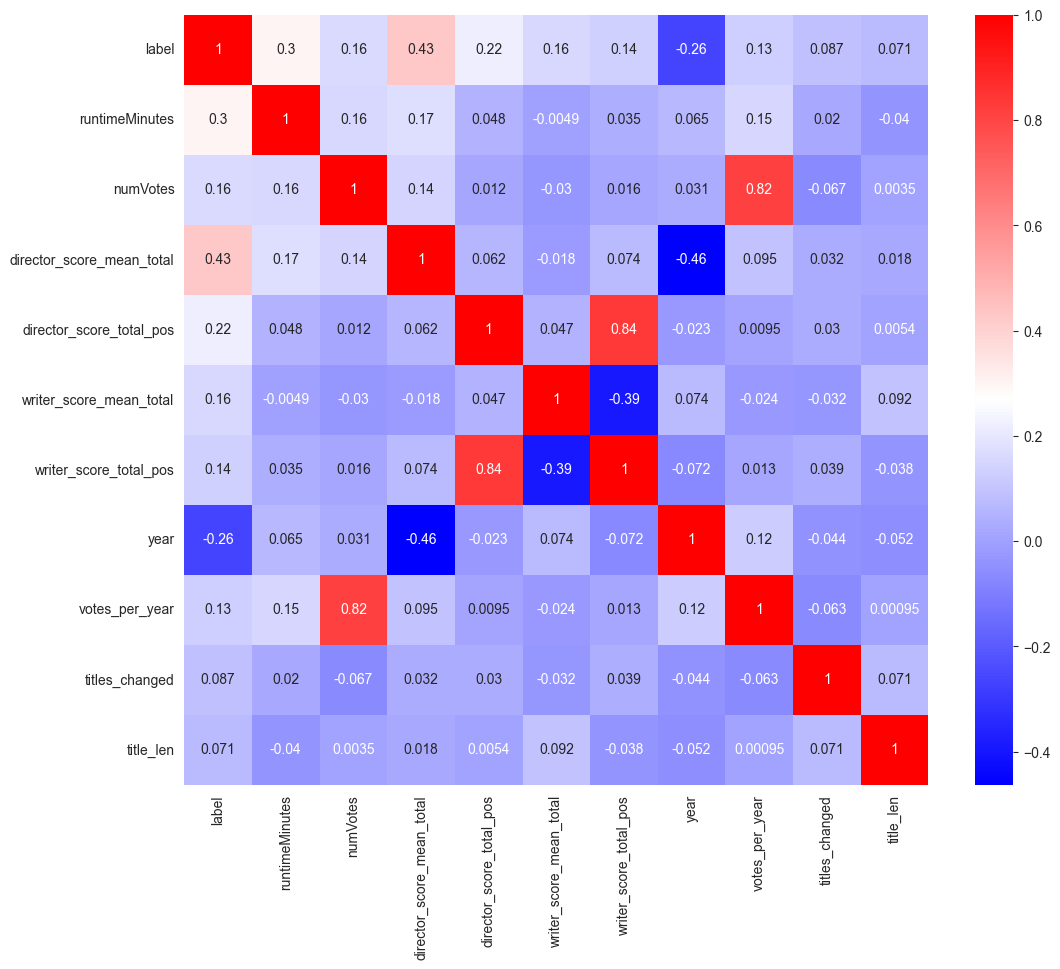

In [115]:
plt.figure(figsize=(12,10))
cor = train.corr()
sns.heatmap(cor, annot=True, cmap="bwr")
plt.show()

array([[<Axes: title={'center': 'runtimeMinutes'}>,
        <Axes: title={'center': 'numVotes'}>,
        <Axes: title={'center': 'director_score_mean_total'}>,
        <Axes: title={'center': 'director_score_total_pos'}>],
       [<Axes: title={'center': 'writer_score_mean_total'}>,
        <Axes: title={'center': 'writer_score_total_pos'}>,
        <Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'votes_per_year'}>],
       [<Axes: title={'center': 'title_len'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

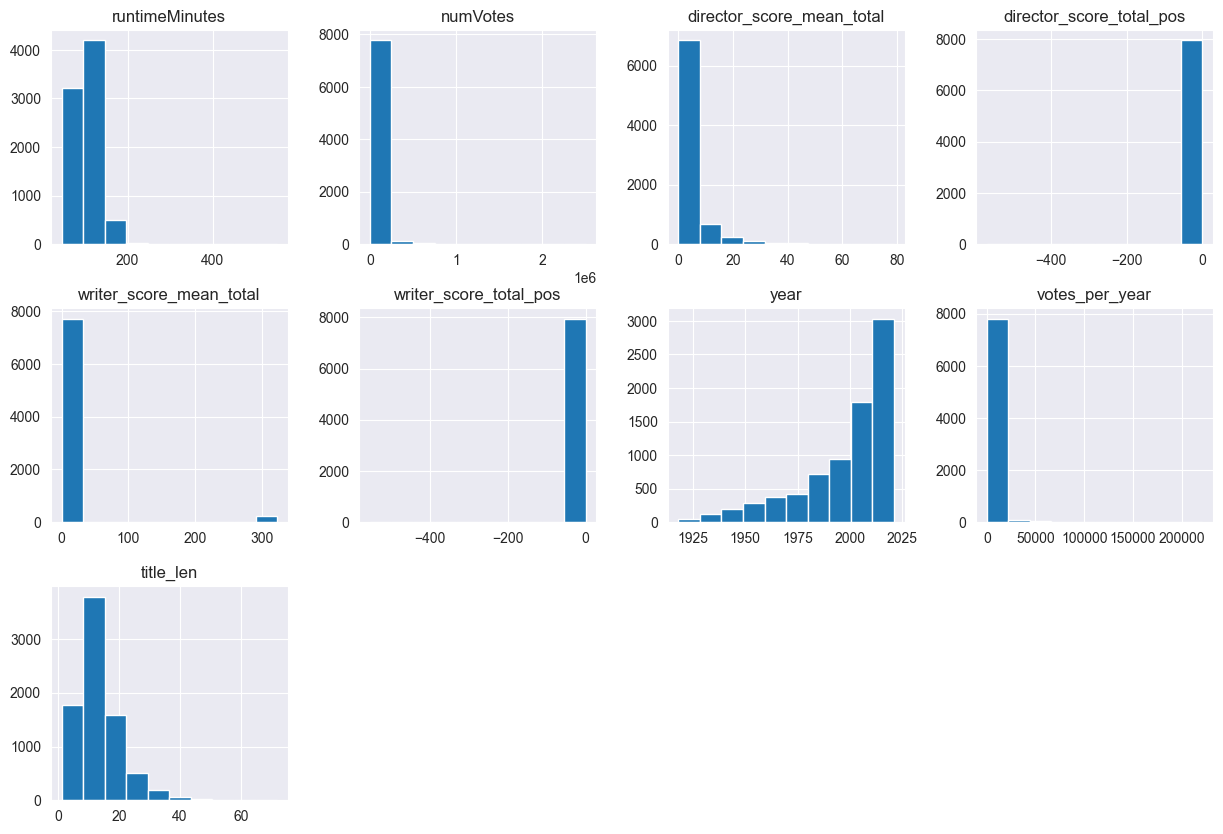

In [116]:
train.hist(layout=(3,4), figsize=(15,10))

In [117]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="error", max_depth=5, )
xgb_model.fit(train_X, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

## Prepare CSV files for kaggle

In [118]:
validation = pd.read_csv("../data/validation_hidden.csv")
validation = dataset.process_dataframe(validation)
validation = validation.drop(unusable_cols, axis=1)

C:\Users\Oliver\PycharmProjects\BigDataProject_IMDB\pipeline\_dataset.py:99: FutureWarning: A grouping was used that is not in the columns of the DataFrame and so was excluded from the result. This grouping will be included in a future version of pandas. Add the grouping as a column of the DataFrame to silence this warning.
  lambda elem: pd.Series(__get_scores(elem, target=self._writer_scores)))


Error: key not found nm0665163
Error: key not found nm0718469
Error: key not found nm0292134
Error: key not found nm0254675
Error: key not found nm0035899
Error: key not found nm0210701
Error: key not found nm0919012
Error: key not found nm0324013
Error: key not found nm0629580
Error: key not found nm0287836
Error: key not found nm0330456
Error: key not found nm0782947
Error: key not found nm0076779
Error: key not found nm0641007
Error: key not found nm0395105
Error: key not found nm0455839
Error: key not found nm0290371
Error: key not found nm0103855
Error: key not found nm0274659
Error: key not found nm0215085
Error: key not found nm0111735
Error: key not found nm0850895
Error: key not found nm0514816
Error: key not found nm0592807
Error: key not found nm0468882
Error: key not found nm0162979
Error: key not found nm0364252
Error: key not found nm0001471
Error: key not found nm0164999
Error: key not found nm0367431
Error: key not found nm0198014
Error: key not found nm0404606
Error: k

In [119]:
test = pd.read_csv("../data/test_hidden.csv")
test = dataset.process_dataframe(test)
test = test.drop(unusable_cols, axis=1)

C:\Users\Oliver\PycharmProjects\BigDataProject_IMDB\pipeline\_dataset.py:99: FutureWarning: A grouping was used that is not in the columns of the DataFrame and so was excluded from the result. This grouping will be included in a future version of pandas. Add the grouping as a column of the DataFrame to silence this warning.
  lambda elem: pd.Series(__get_scores(elem, target=self._writer_scores)))


Error: key not found nm0243295
Error: key not found nm0670643
Error: key not found nm0516001
Error: key not found nm0316539
Error: key not found nm0570985
Error: key not found nm0793646
Error: key not found nm0928781
Error: key not found nm0225555
Error: key not found nm0485647
Error: key not found nm0087831
Error: key not found nm0506797
Error: key not found nm0239069
Error: key not found nm0076779
Error: key not found nm0649907
Error: key not found nm0257129
Error: key not found nm0039107
Error: key not found nm0000059
Error: key not found nm0757940
Error: key not found nm0834744
Error: key not found nm0290371
Error: key not found nm0348175
Error: key not found nm0290802
Error: key not found nm0006615
Error: key not found nm0335093
Error: key not found nm0218840
Error: key not found nm0051926
Error: key not found nm0624809
Error: key not found nm0359457
Error: key not found nm0002134
Error: key not found nm0505610
Error: key not found nm0572132
Error: key not found nm0449084
Error: k

In [120]:
validation["label"] = xgb_model.predict(validation)
test["label"] = xgb_model.predict(test)

validation["label"].astype(bool).to_csv("val_result.csv", index=False, header=None)
test["label"].astype(bool).to_csv("test_result.csv", index=False, header=None)

for file in ["val_result.csv", "test_result.csv"]:
    with open(file, 'r+') as f:
        f.seek(0,2)                    
        size=f.tell()               
        f.truncate(size-2)